# SWOP script 5 - Linear Mixed Effects Analysis
## 900-1000 ms time window

This script imports a CSV file generated by the script *SWOP 4 - Measure ERPS* and performs linear mixed effects modelling.

Following general best practices, we are using **individual trial** data. Note that outliers (defined as data points at the level of subjets/trials/channels with abs(*z*) > 2.5) have been removed in script 4. 

A few technical notes:
- while LME is most commonly run using the *lmer()* function in the *lme4* package, we instead use the *bam()* function in the *mgcv* package. While mgcv/bam is written for generalized additive modelling, it allows for LME by using the *bs='re'* flag for smooths (where  're' stands for 'random effects'). The *bam()* function is parallelized, as well as being well-optimized, making it much faster to run, and without convergence errors that sometimes plague *lmer()* models
- best practices  in LME modelling tend to encourage full random effects models, and also by-item random effects and even random slopes for items within subjects. However, these models quickly become computationally very expensive, both in terms of time and RAM required. They are computed  here, but it is impossible to generate the tables of results and effet sizes with *emmeans()*, nor plot the contrasts of interest. My past experience, as well as experience with this dataset, is that these more elaborate random effects models do generate much smaller AIC values, and higher explained variance of the models. However, they do not in any appreciable way impact the general pattern of results (in terms of what's significant in the ANOVA tables, nor the effect sizes of our contrasts of interest). For these reasons, the models we ultimately present are not the "best" in the sense of AIC values or explained variance, but they tell efefctively the same story. For reference, however, the more complex models are computed and summarized here for reference. 

---
Copyright 2016-21  [Aaron J Newman](https://github.com/aaronjnewman), [NeuroCognitive Imaging Lab](http://ncil.science), [Dalhousie University](https://dal.ca)

Released under the [BSD 3-clause license](https://opensource.org/licenses/BSD-3-Clause)

---

## Load necessary libraries

In [1]:
date()

[1] "Sun Aug 29 23:33:00 2021"

In [2]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(mgcv)
library(parallel)
# library(viridis)
library(emmeans)
library(sjPlot)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: nlme


Attaching package: 'nlme'


The following object is masked from 'package:dplyr':

    collapse


This is mgcv 1.8-36. For overview type 'help("mgcv-package")'.

Registered S3 methods overwritten by 'parameters':
  method                           from      
  as.double.parameters_kurtosis    datawizard
  as.double.parameters_skewness    datawizard
  as.double.parameters_smoothness  datawizard
  as.numeric.parameters_kurtosis   datawizard
  as.numeric.parameters_skewness   datawizard
  as.numeric.parameters_smoothness datawizard
  print.parameters_distribution    datawizard
  print.parameters_kurtosis        datawizard
  print.parameters_skewness        datawizard
  summary.parameters_kurtosis      datawizard
  summary.parameters_skewness      datawizard

#

## Set parameters for this analysis

In [22]:
component = '900-1000'
expt = 'SWOP'
data_path = '../group_data/'
out_path = '../results/'

data_file = paste(data_path, 'SWOP_ERP_measurements.csv', sep="")

# num parallel processes for bam(). Should be less than the number of threads supported by your CPU
num_cores = 7

options("scipen"=100, "digits"=5)  # force decimal instead of scientific notation

## Load Data

In [4]:
dat <- read.csv(data_file,
               colClasses=c('factor', 'numeric', 'factor', 
                            'factor', 'factor', 'factor', 
                            'factor',  'factor', 'factor', 
                            'numeric', 'factor', 'factor',
                            'factor', 'factor', 'factor', 
                            'factor', 'numeric', 'factor',
                            'numeric'
                           )
               )

dat$ROI <- factor(dat$ROI, levels=c('L_Ant', 'M_Ant', 'R_Ant',
                                       'L_Cent', 'M_Cent', 'R_Cent',
                                       'L_Post', 'M_Post', 'R_Post'
                                      ))

# specify ordering of condtiions, for plots and contrats
dat$Adverb <- factor(dat$Adverb, levels=c('kanske', 'hemma', 'idag'))
# Force contrasts as V3-V2
dat$SentPos <- factor(dat$SentPos, levels=c('V3', 'V2'))

### Select only data for ERP component of interest

In [5]:
dat <- subset(dat, Component==component | Component=='baseline')
dat <- droplevels(dat)

### Remove missing data 

In [6]:
dat <- dat[complete.cases(dat), ]

## Summary/Descriptives

In [7]:
summary(dat)

    Subject        Trial.Time          Condition          ROI       
 s_04nm : 6275   Min.   :   1157   V2/hemma :20236   L_Post :18441  
 s_21ma : 6152   1st Qu.: 497829   V2/idag  :20113   L_Cent :18440  
 s_19am : 6128   Median :1070614   V2/kanske:20266   R_Cent :18307  
 s_27lm : 6126   Mean   :1096198   V3/hemma :20369   R_Ant  :18148  
 s_25ks : 6124   3rd Qu.:1653481   V3/idag  :20183   R_Post :18122  
 s_12wg : 6117   Max.   :2977152   V3/kanske:20438   L_Ant  :18052  
 (Other):84683                                       (Other):12095  
    Channel         Sentence      postphrase  pronoun_noun questiondisplay.ACC
 TP7    : 4773   180    :   534   0.0:20063   N:60827      0: 19629           
 TP8    : 4770   219    :   532   1.0:22250   P:60778      1:101976           
 P7     : 4767   231    :   532   2.0:16650                                   
 T8     : 4763   287    :   532   3.0:24226                                   
 T7     : 4742   290    :   531   4.0:21829          

In [8]:
str(dat)

'data.frame':	121605 obs. of  19 variables:
 $ Subject            : Factor w/ 20 levels "s_04nm","s_07ba",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Trial.Time         : num  34102 34102 34102 34102 34102 ...
 $ Condition          : Factor w/ 6 levels "V2/hemma","V2/idag",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ ROI                : Factor w/ 9 levels "L_Ant","M_Ant",..: 1 1 1 1 4 4 4 4 7 7 ...
 $ Channel            : Factor w/ 27 levels "C3","C4","CP3",..: 6 8 10 12 1 3 24 26 15 17 ...
 $ Sentence           : Factor w/ 240 levels "10","101","102",..: 215 215 215 215 215 215 215 215 215 215 ...
 $ postphrase         : Factor w/ 6 levels "0.0","1.0","2.0",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ pronoun_noun       : Factor w/ 2 levels "N","P": 1 1 1 1 1 1 1 1 1 1 ...
 $ questiondisplay.ACC: Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ questiondisplay.RT : num  213 213 213 213 213 213 213 213 213 213 ...
 $ sentence_no        : Factor w/ 40 levels "1.0","10.0","11.0",..: 15 15 15 15 15 15 15 15 15 15 ...
 $ s

## Get counts of trials in each cell of design
We select data from Cz just to avoid repeated measures for all the electrodes

In [9]:
crosstab <- xtabs(~ SentPos + Adverb, data=subset(dat, Component==component & Channel=='Cz'))
ftable(crosstab) # print table 
summary(crosstab) #

        Adverb kanske hemma idag
SentPos                         
V3                658   664  669
V2                650   654  638

Call: xtabs(formula = ~SentPos + Adverb, data = subset(dat, Component == 
    component & Channel == "Cz"))
Number of cases in table: 3933 
Number of factors: 2 
Test for independence of all factors:
	Chisq = 0.25, df = 2, p-value = 0.88

### Visualize distributions

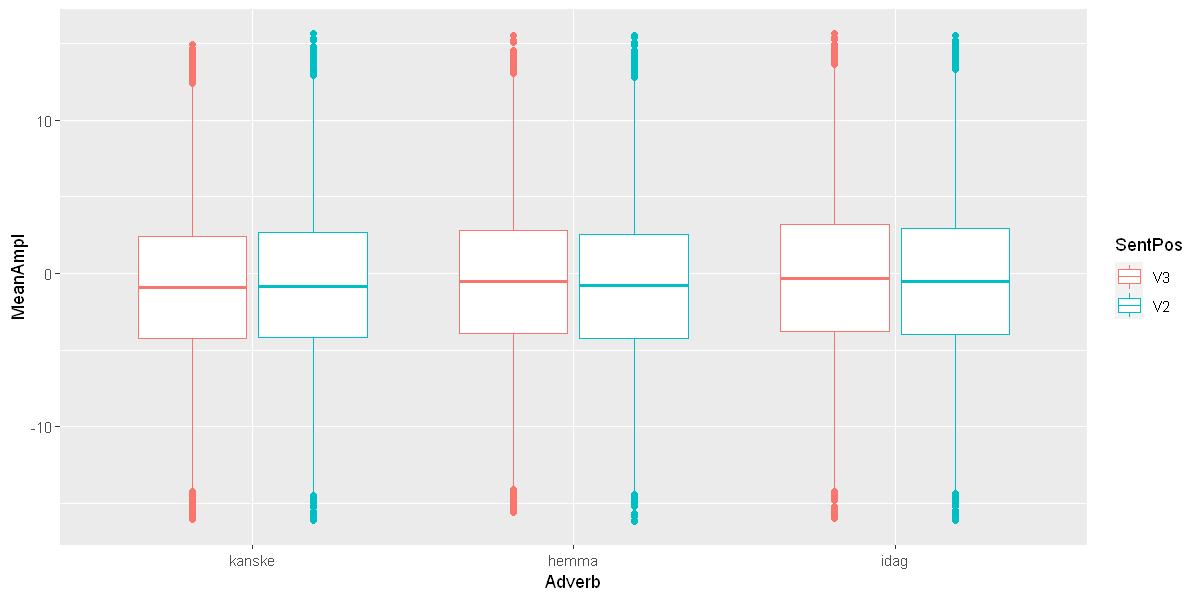

In [10]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(dat, aes(y=MeanAmpl, x=Adverb, col=SentPos)) + 
    geom_boxplot() 

## LME modelling

Note: we use the `bam()` function but fit linear models.

### Fit a simple-but-full model without baseline

In [11]:
cl <- makeCluster(num_cores)  

m0 <- bam(MeanAmpl ~ (Adverb * SentPos * ROI)
          + s(Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)


Method: fREML   Optimizer: perf newton
full convergence after 8 iterations.
Gradient range [-0.0000032627,-0.0000000000065761]
(score 371351 & scale 26.267).
Hessian positive definite, eigenvalue range [9.2618,60776].
Model rank =  74 / 74 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

             k'  edf k-index p-value
s(Subject) 20.0 18.8      NA      NA


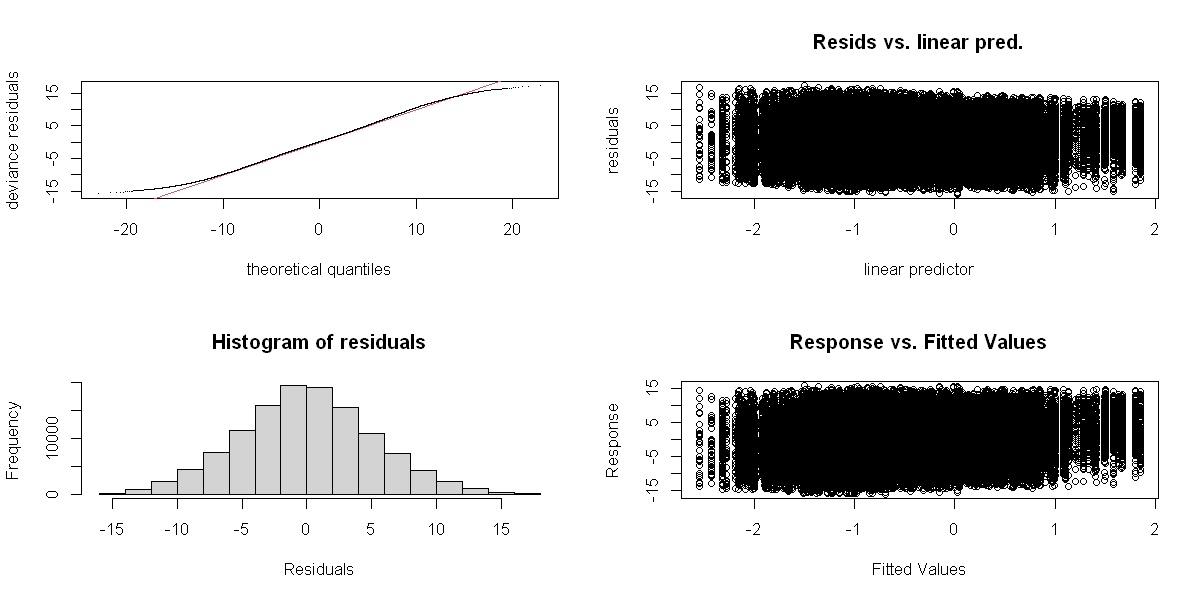

In [12]:
gam.check(m0)

In [19]:
anova(m0)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb * SentPos * ROI) + s(Subject, bs = "re")

Parametric Terms:
                   df    F              p-value
Adverb              2 2.92                0.054
SentPos             1 0.14                0.707
ROI                 8 8.19     0.00000000003841
Adverb:SentPos      2 1.68                0.186
Adverb:ROI         16 8.39 < 0.0000000000000002
SentPos:ROI         8 0.87                0.545
Adverb:SentPos:ROI 16 5.92     0.00000000000033

Approximate significance of smooth terms:
            edf Ref.df    F             p-value
s(Subject) 18.8   19.0 78.7 <0.0000000000000002

## Include baseline as fixed effect, not interacting with other factors

In [14]:
cl <- makeCluster(num_cores)  

m_b_nox <- bam(MeanAmpl ~ (Adverb * SentPos * ROI) + baseline
          + s(Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Include baseline as a fixed effect, *fully interacting* with other factors

In [15]:
cl <- makeCluster(num_cores)  

m_full <- bam(MeanAmpl ~ (Adverb * SentPos * ROI * baseline)
          + s(Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Add random intercepts for items (sentences) as well as subjects

In [16]:
cl <- makeCluster(num_cores)  

mf_4w_rei <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4
          + s(Subject, bs='re') + s(Sentence, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Allow only 3-way interactions

In [17]:
cl <- makeCluster(num_cores)  

mf_3w_rei <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^3
          + s(Subject, bs='re') + s(Sentence, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Random slopes for items (sentences) within subjects, and random slopes for Channel within subjects, 4 way interactions

This takes a long time to fit, and requires lots of RAM

In [18]:
cl <- makeCluster(num_cores)  

mf_4w_recsis <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4
          + s(Channel, Subject, bs='re') + s(Sentence, Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Random slopes for items (sentences) within subjects, and random slopes for Channel within subjects, 3 way interactions

In [19]:
cl <- makeCluster(num_cores)  

mf_3w_recsis <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^3
          + s(Channel, Subject, bs='re') + s(Sentence, Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

## Random intercepts by item, not nested in subjects

In [20]:
cl <- makeCluster(num_cores)  

mf_4w_reci <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4
          + s(Channel, Subject, bs='re') + s(Sentence, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

## Compare models

In [21]:
AICtab <- as.data.frame(AIC(m0, m_full, m_b_nox, 
                            mf_3w_rei, mf_3w_recsis,
                            mf_4w_rei, mf_4w_recsis, mf_4w_reci
                           )) 
AICtab$deltaAIC <-AICtab$AIC - min(AICtab$AIC)
AICtab[order(AICtab$AIC),]

,df,AIC,deltaAIC
,<dbl>,<dbl>,<dbl>
mf_4w_recsis,5194.476,662355,0.000
mf_3w_recsis,5178.443,662366,11.107
mf_4w_reci,815.706,734201,71846.407
mf_3w_rei,335.497,737158,74803.377
mf_4w_rei,351.502,737167,74812.673
m_full,127.799,740818,78463.424
m_b_nox,74.798,740850,78495.569
m0,73.786,742617,80262.200


---
## Explore best model

### Best Model

**`mf_4w_recsis`** has smallest AIC

However, the random effects structure is so complex that we can't generate plots of this model below (requires more RAM than we have; takes > 24 h to fit and then maybe crashes). For those we use the model **`mf_4w_reci`**, which is the same but with only random intercepts by sentence, not sentence-by-subject RE

The plotted effect sizes and confidence intervals do not change in any visually-detectable way between these models with different random effects structures anyway.

In [22]:
anova(mf_4w_recsis)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4 + s(Channel, 
    Subject, bs = "re") + s(Sentence, Subject, bs = "re")

Parametric Terms:
                            df     F              p-value
Adverb                       2  1.48              0.22873
SentPos                      1  0.13              0.71565
ROI                          8  6.62          0.000000011
baseline                     1 91.53 < 0.0000000000000002
Adverb:SentPos               2  1.16              0.31257
Adverb:ROI                  16 19.00 < 0.0000000000000002
Adverb:baseline              2  9.60          0.000067456
SentPos:ROI                  8  1.87              0.06044
SentPos:baseline             1  7.39              0.00658
ROI:baseline                 8  3.93              0.00012
Adverb:SentPos:ROI          16 12.93 < 0.0000000000000002
Adverb:SentPos:baseline      2  4.78              0.00838
Adverb:ROI:baseline         16  3.50          0.0000

### Write ANOVA table to text file

In [23]:
capture.output(anova(mf_4w_recsis), file=paste(out_path, 'anova_table_', component, '.txt'))

In [23]:
summary(mf_4w_recsis)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4 + s(Channel, 
    Subject, bs = "re") + s(Sentence, Subject, bs = "re")

Parametric coefficients:
                                         Estimate Std. Error t value
(Intercept)                              -0.79045    0.17900   -4.42
Adverbhemma                              -0.33327    0.20353   -1.64
Adverbidag                               -0.07458    0.20326   -0.37
SentPosV2                                -0.07416    0.20358   -0.36
ROIM_Ant                                 -0.60188    0.28466   -2.11
ROIR_Ant                                 -0.30432    0.17832   -1.71
ROIL_Cent                                -0.30747    0.17743   -1.73
ROIM_Cent                                -0.81640    0.28714   -2.84
ROIR_Cent                                -0.69631    0.17804   -3.91
ROIL_Post                                 0.32533    0.17760    1.83
ROIM_Post                               

### View the model that gives best AIC, within computational feasibility

In [24]:
mod = mf_4w_rei #mf_4w_rei

In [25]:
anova(mod)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4 + s(Subject, 
    bs = "re") + s(Sentence, bs = "re")

Parametric Terms:
                            df     F              p-value
Adverb                       2  1.30                0.272
SentPos                      1  0.13                0.714
ROI                          8 10.35    0.000000000000013
baseline                     1 42.35    0.000000000076768
Adverb:SentPos               2  1.35                0.260
Adverb:ROI                  16  8.70 < 0.0000000000000002
Adverb:baseline              2  0.62                0.536
SentPos:ROI                  8  1.04                0.403
SentPos:baseline             1  5.58                0.018
ROI:baseline                 8  2.13                0.030
Adverb:SentPos:ROI          16  6.76    0.000000000000001
Adverb:SentPos:baseline      2  1.71                0.182
Adverb:ROI:baseline         16  0.94                0.524
SentPos:ROI:

In [26]:
summary(mod)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4 + s(Subject, 
    bs = "re") + s(Sentence, bs = "re")

Parametric coefficients:
                                         Estimate Std. Error t value
(Intercept)                              -0.79644    0.19181   -4.15
Adverbhemma                              -0.24154    0.19465   -1.24
Adverbidag                                0.05386    0.19422    0.28
SentPosV2                                 0.04825    0.13155    0.37
ROIM_Ant                                 -0.54200    0.21439   -2.53
ROIR_Ant                                 -0.26479    0.13117   -2.02
ROIL_Cent                                -0.33082    0.12887   -2.57
ROIM_Cent                                -0.67724    0.22031   -3.07
ROIR_Cent                                -0.66108    0.13033   -5.07
ROIL_Post                                 0.29388    0.12908    2.28
ROIM_Post                                -0.91750    0.216

## View results

In [27]:
contr <- emmeans(mod,  pairwise ~ SentPos | Adverb * ROI)

contr_tab = contr$contrasts %>% as.data.frame()
ncomp = nrow(contr_tab)
contr_tab$'p (raw)'   = round(contr_tab$'p.value', 4)
contr_tab$'p (FDR BH)' = round(p.adjust(contr_tab$'p.value', method = 'BH', n = ncomp), 4)
contr_tab <- subset(contr_tab, select=-c(p.value))
contr_tab

NOTE: A nesting structure was detected in the fitted model:
    Sentence %in% Adverb

NOTE: Results may be misleading due to involvement in interactions



,contrast,Adverb,ROI,estimate,SE,df,t.ratio,p (raw),p (FDR BH)
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,V3 - V2,kanske,L_Ant,-0.118821,0.12915,121255,-0.92000,0.3576,0.4388
2,V3 - V2,hemma,L_Ant,-0.394326,0.12937,121255,-3.04801,0.0023,0.0062
3,V3 - V2,idag,L_Ant,-0.141756,0.13050,121255,-1.08626,0.2774,0.3566
4,V3 - V2,kanske,M_Ant,0.012962,0.27220,121255,0.04762,0.9620,0.9620
5,V3 - V2,hemma,M_Ant,-0.574777,0.27426,121255,-2.09577,0.0361,0.0573
6,V3 - V2,idag,M_Ant,-0.036977,0.27491,121255,-0.13450,0.8930,0.9274
7,V3 - V2,kanske,R_Ant,-0.032366,0.12928,121255,-0.25036,0.8023,0.8665
8,V3 - V2,hemma,R_Ant,-0.418779,0.12939,121255,-3.23650,0.0012,0.0041
9,V3 - V2,idag,R_Ant,0.359894,0.13012,121255,2.76592,0.0057,0.0128


## Get effect sizes on differences 
Cohen's *d*

### Plot effect sizes for all V3-V2 contrasts

Also save a PDF version of the plot

Since 'object' is a list, we are using the contrasts already present.



png 
  2

Since 'object' is a list, we are using the contrasts already present.



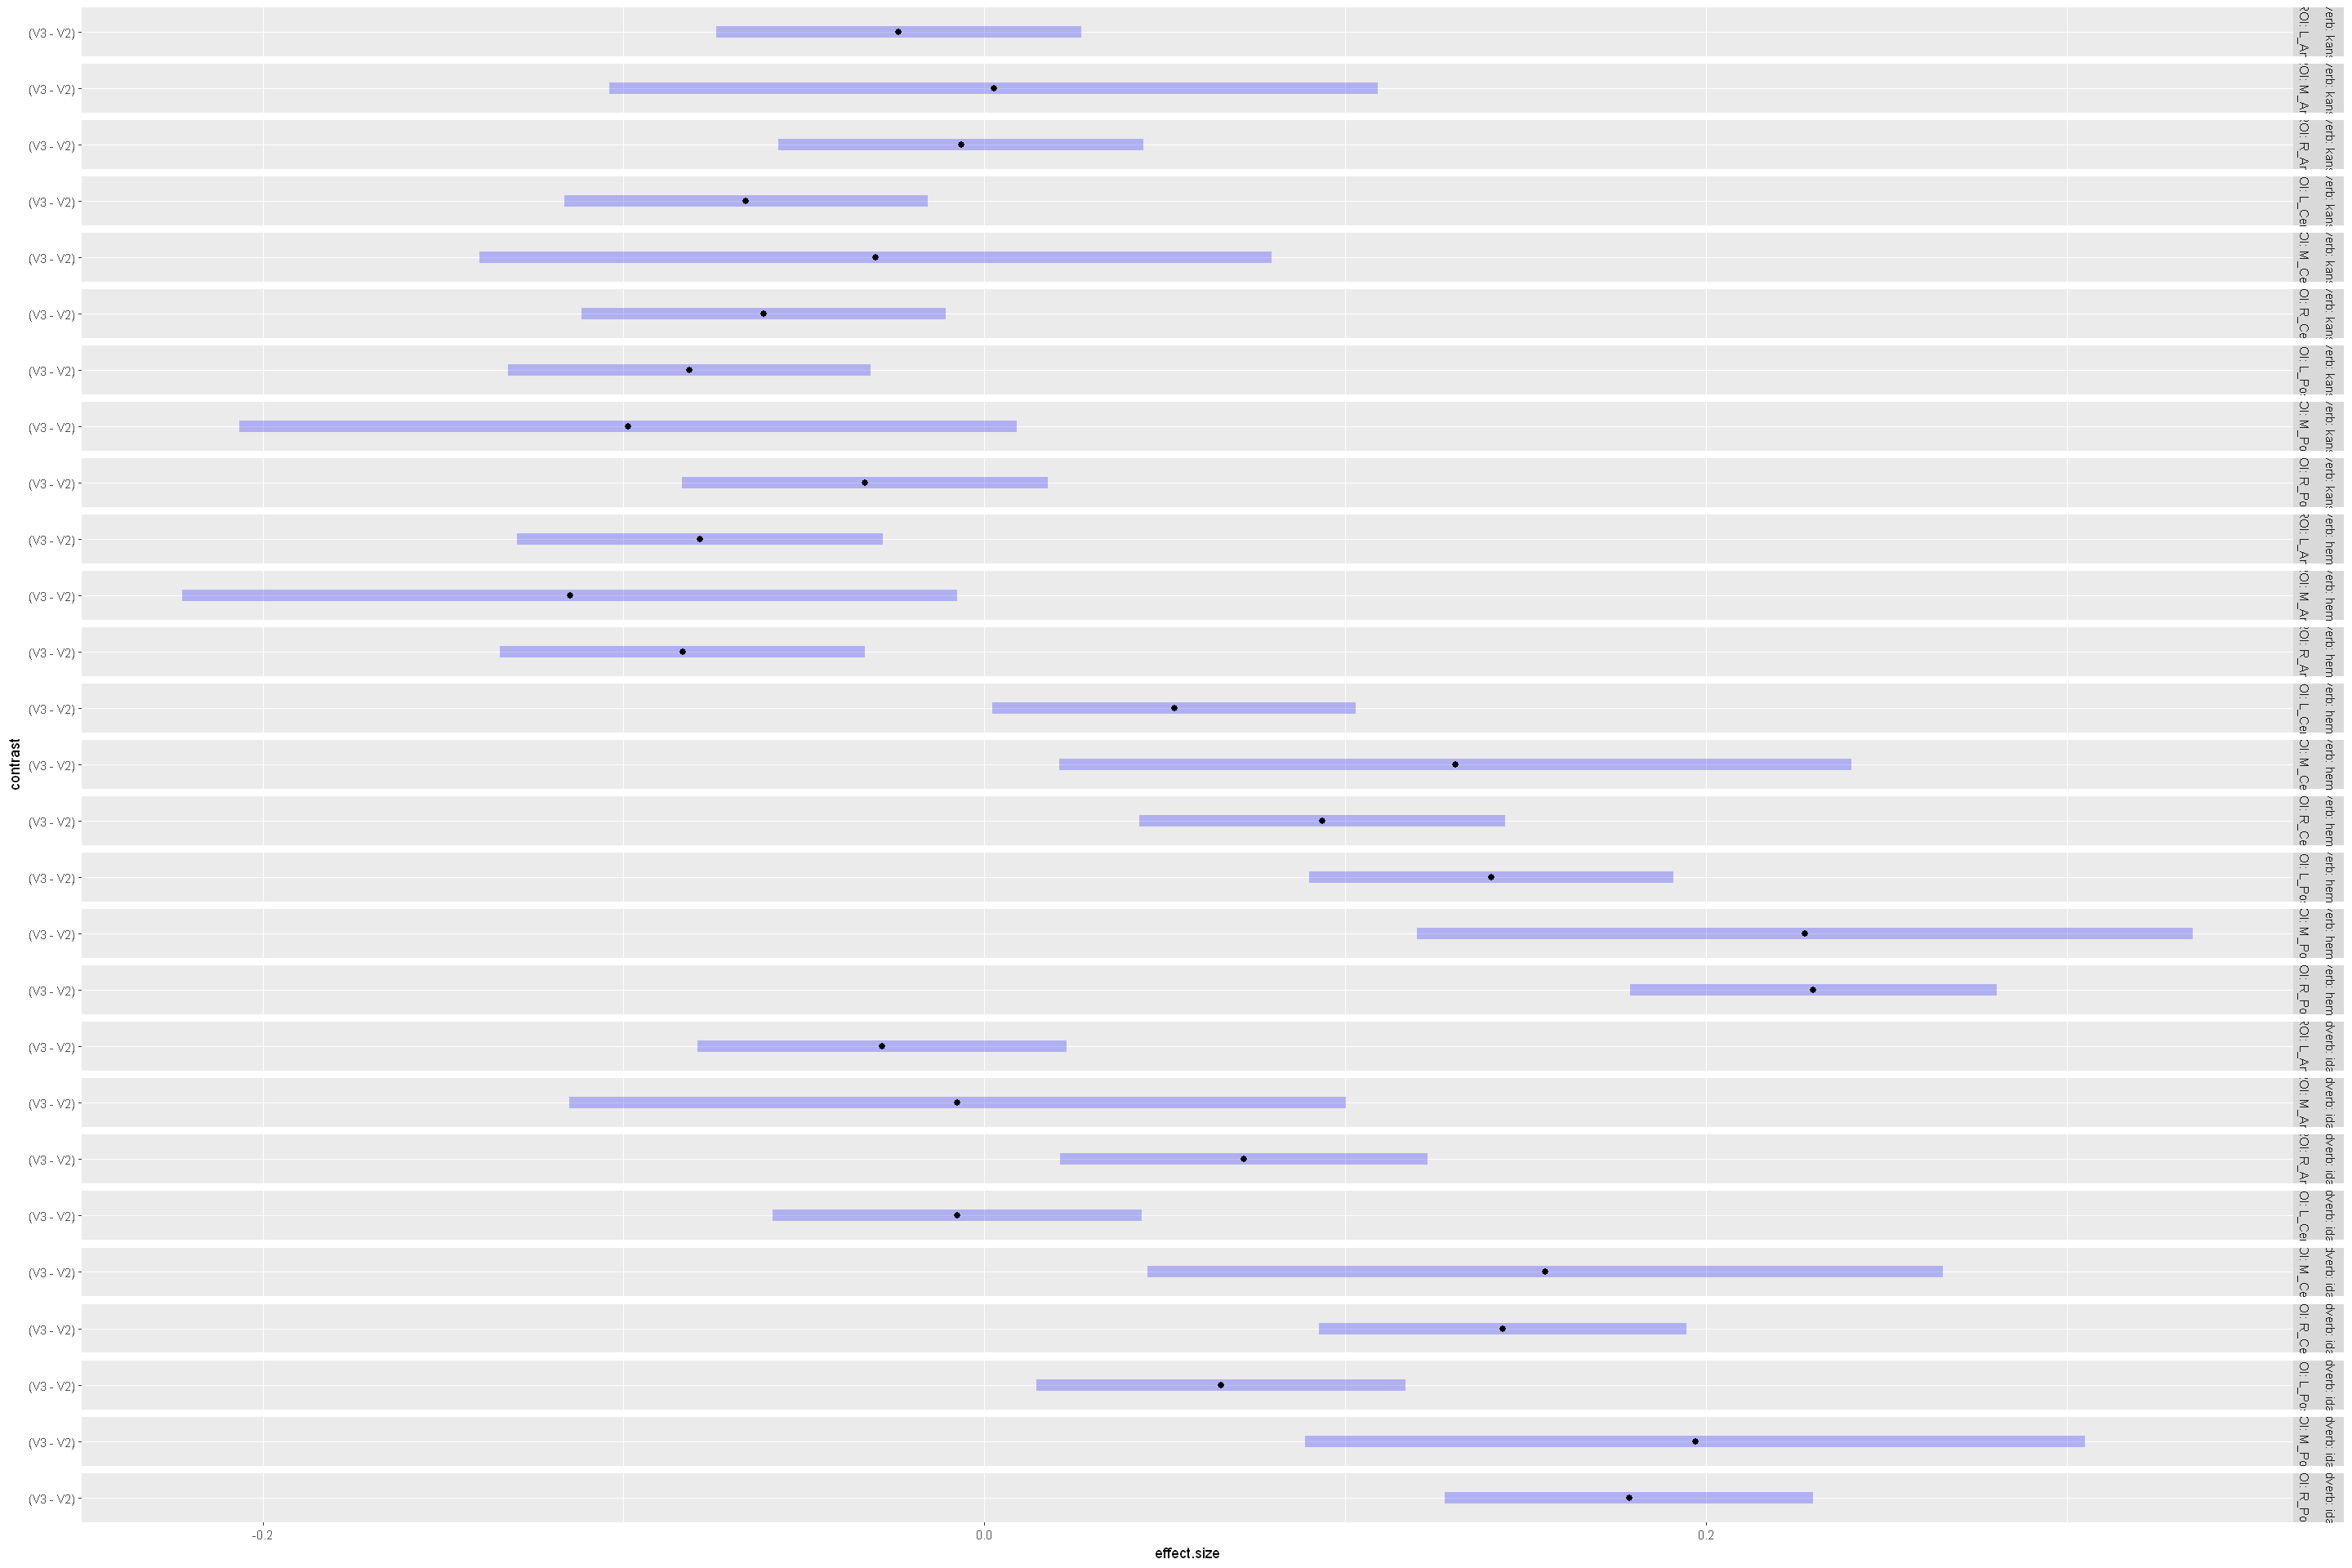

In [28]:
pdf(paste(out_path, 'figures/R plots/', 'lme_effect_plot_', component, '.pdf', sep="")) 
plot(eff_size(contr, sigma = sigma(mod), edf = 125000))
dev.off() 
options(repr.plot.width=24, repr.plot.height=16)
plot(eff_size(contr, sigma = sigma(mod), edf = 125000))

In [29]:
eff_tab <- eff_size(contr, sigma = sigma(mod), edf = 125000) %>% as.data.frame()
full_tab <- contr_tab %>% full_join(eff_tab, by=c("ROI", 'Adverb'), suffix = c(".ctr", ".eff"))
full_tab

Since 'object' is a list, we are using the contrasts already present.



contrast.ctr,Adverb,ROI,estimate,SE.ctr,df.ctr,t.ratio,p (raw),p (FDR BH),contrast.eff,effect.size,SE.eff,df.eff,lower.CL,upper.CL
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
V3 - V2,kanske,L_Ant,-0.118821,0.12915,121255,-0.92000,0.3576,0.4388,(V3 - V2),-0.0237348,0.025799,121255,-0.0742998,0.026830
V3 - V2,hemma,L_Ant,-0.394326,0.12937,121255,-3.04801,0.0023,0.0062,(V3 - V2),-0.0787676,0.025843,121255,-0.1294189,-0.028116
V3 - V2,idag,L_Ant,-0.141756,0.13050,121255,-1.08626,0.2774,0.3566,(V3 - V2),-0.0283161,0.026068,121255,-0.0794083,0.022776
V3 - V2,kanske,M_Ant,0.012962,0.27220,121255,0.04762,0.9620,0.9620,(V3 - V2),0.0025892,0.054372,121255,-0.1039799,0.109158
V3 - V2,hemma,M_Ant,-0.574777,0.27426,121255,-2.09577,0.0361,0.0573,(V3 - V2),-0.1148130,0.054784,121255,-0.2221879,-0.007438
V3 - V2,idag,M_Ant,-0.036977,0.27491,121255,-0.13450,0.8930,0.9274,(V3 - V2),-0.0073862,0.054915,121255,-0.1150180,0.100246
V3 - V2,kanske,R_Ant,-0.032366,0.12928,121255,-0.25036,0.8023,0.8665,(V3 - V2),-0.0064651,0.025824,121255,-0.0570789,0.044149
V3 - V2,hemma,R_Ant,-0.418779,0.12939,121255,-3.23650,0.0012,0.0041,(V3 - V2),-0.0836520,0.025847,121255,-0.1343116,-0.032992
V3 - V2,idag,R_Ant,0.359894,0.13012,121255,2.76592,0.0057,0.0128,(V3 - V2),0.0718896,0.025992,121255,0.0209466,0.122833


### Write above table to file

## Plot Model

NOTE: A nesting structure was detected in the fitted model:
    Sentence %in% Adverb

NOTE: Results may be misleading due to involvement in interactions



png 
  2

NOTE: A nesting structure was detected in the fitted model:
    Sentence %in% Adverb

NOTE: Results may be misleading due to involvement in interactions



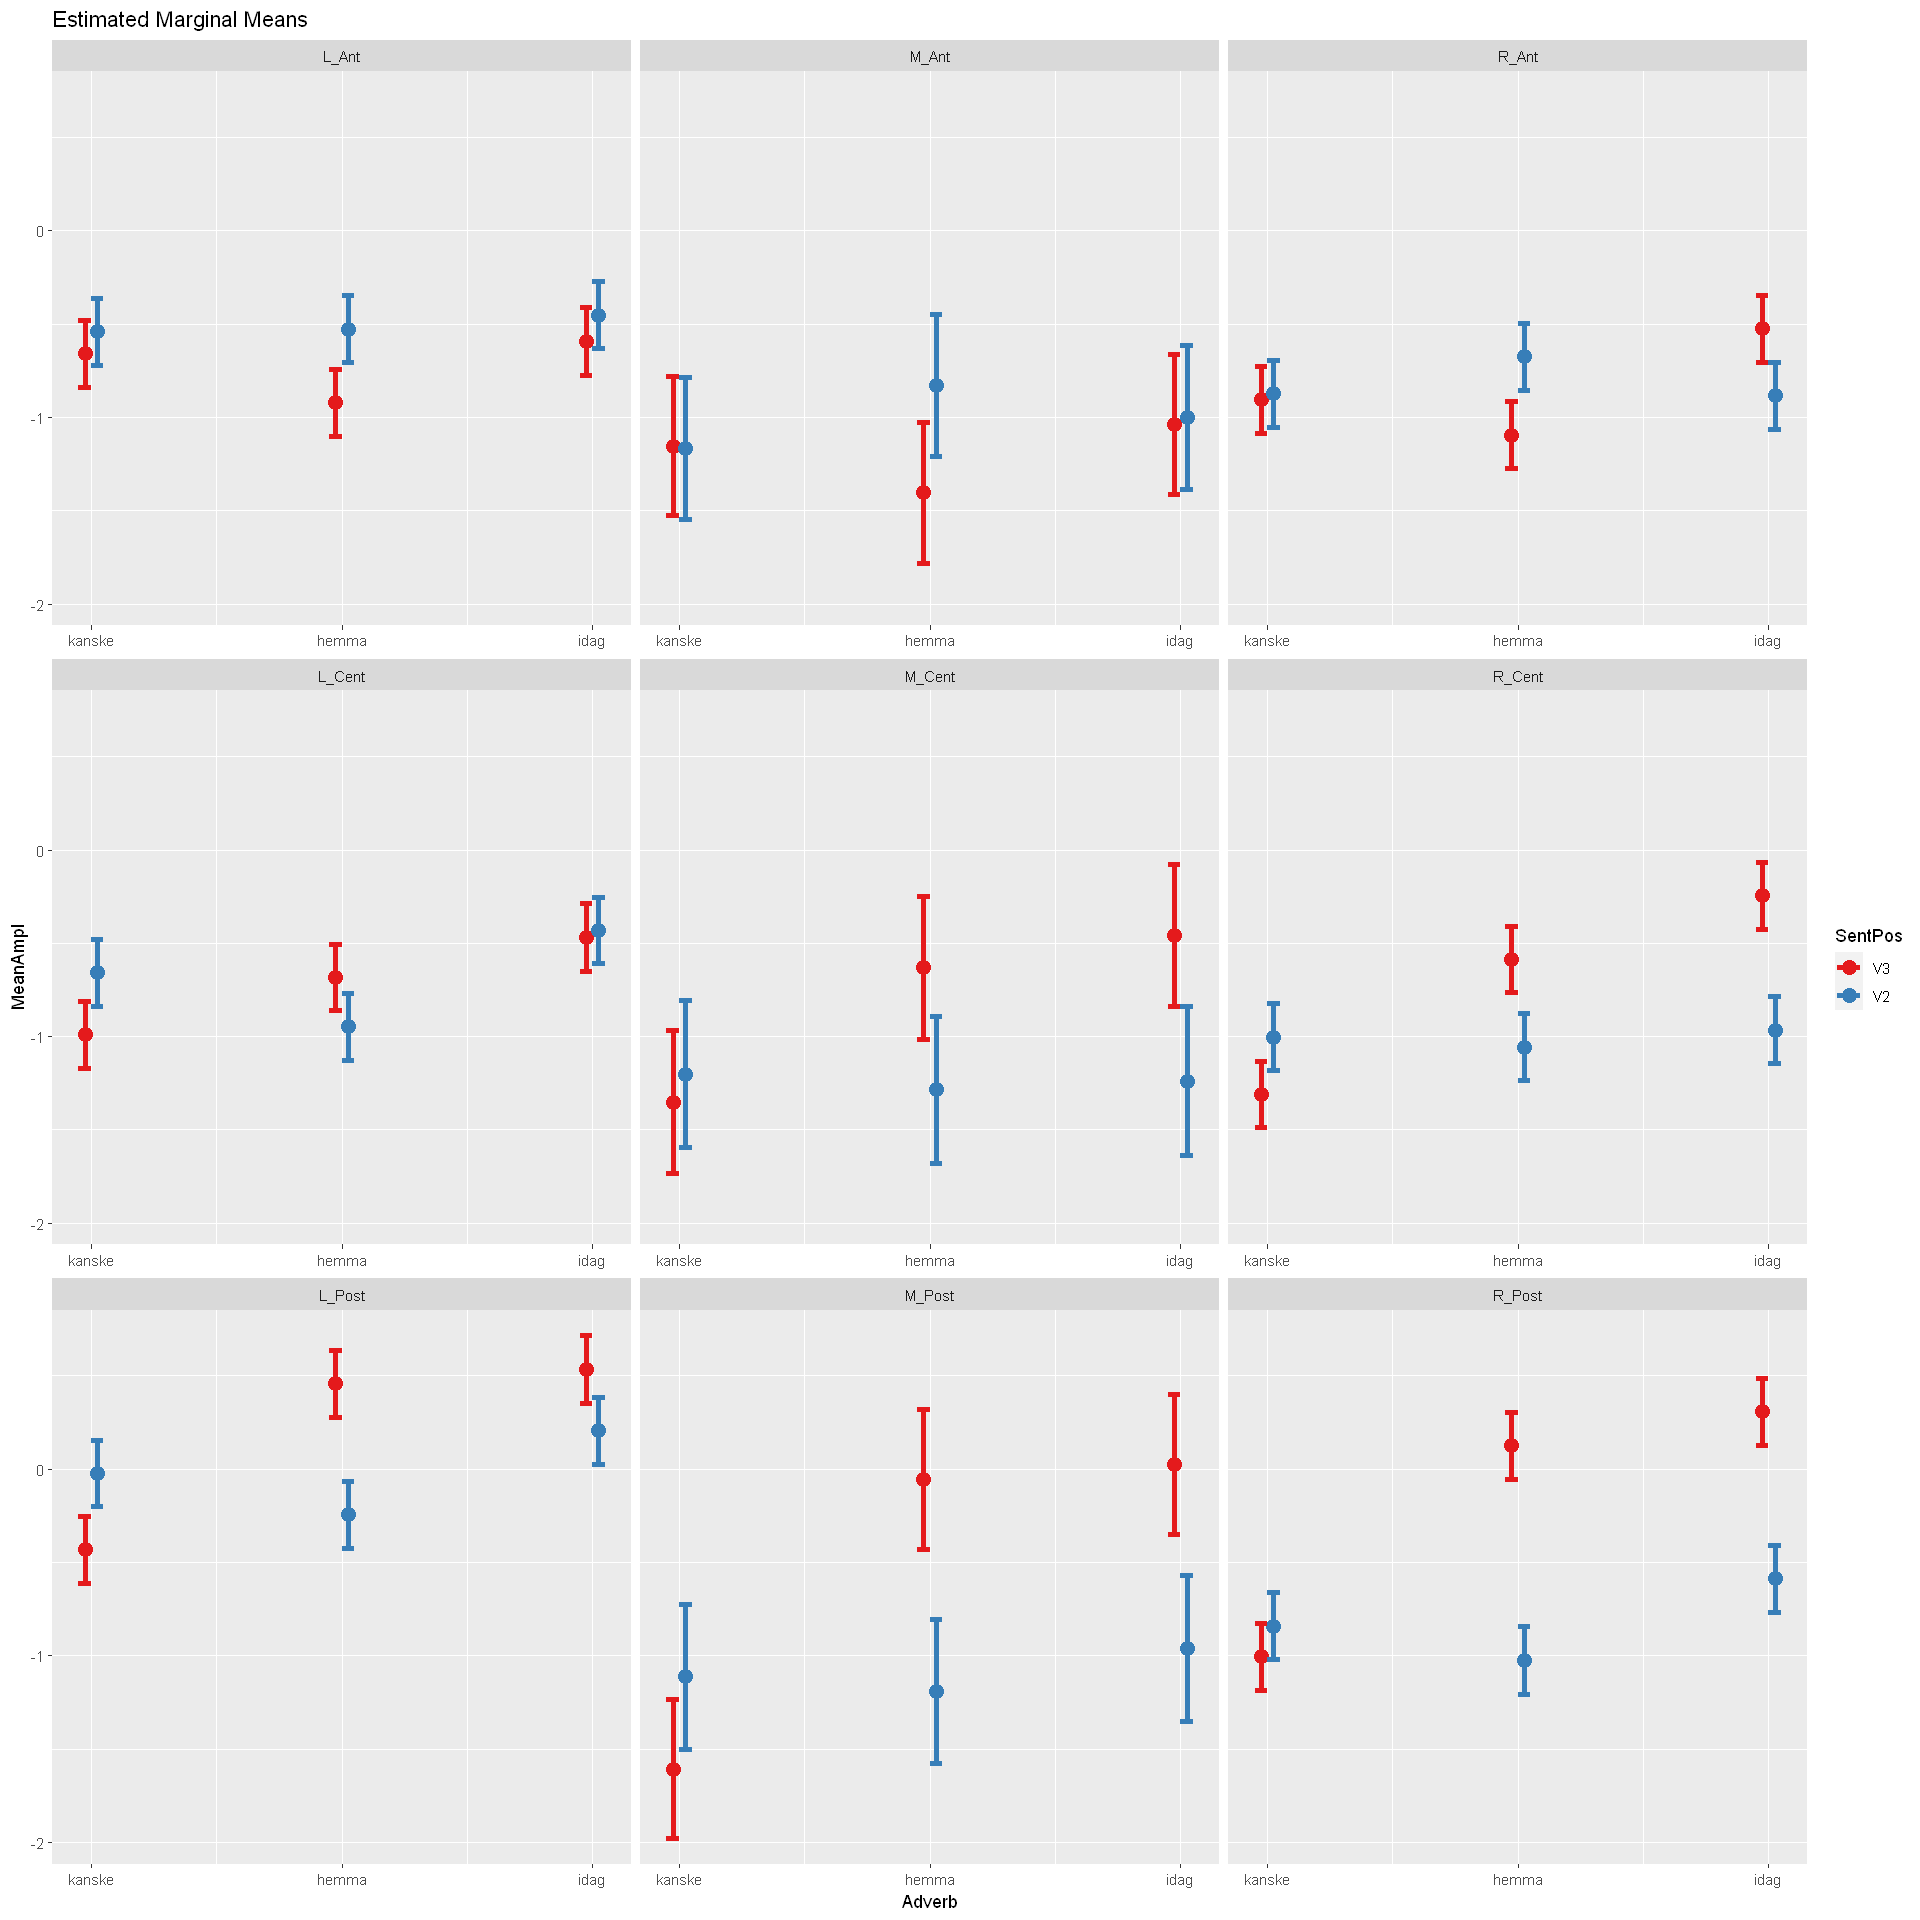

In [31]:
# save PDF
pdf(paste(out_path, 'figures/R plots/', 'lme_model_plot_', component, '.pdf', sep="")) 
plot_model(mod, 
           type='emm',
           terms=c('Adverb', 'SentPos', 'ROI'),
           dot.size=4, line.size=1.5,  panel.minor.gridcol = 1,
           title='Estimated Marginal Means'
          )
dev.off() 

# plot in this notebook
options(repr.plot.width=16, repr.plot.height=16)
plot_model(mod, 
           type='emm',
           terms=c('Adverb', 'SentPos', 'ROI'),
           dot.size=4, line.size=1.5,  panel.minor.gridcol = 1,
           title='Estimated Marginal Means'
          )

In [32]:
date()

[1] "Sun Aug 29 13:23:46 2021"